# West Main Street Analysis - 1861928

<span style="font-size: 1.2em;">Created by: bergstromn@kalamazoocity.org</span>   
<span style="font-size: 1.2em;">Created on: 2024-12-13</span>   
<span style="font-size: 1.2em;">Organization: City of Kalamazoo</span>   
<span style="font-size: 1.2em;">Created by: bergstromn@kalamazoocity.org</span>
<span style="font-size: 1.2em;">Analysis ID: 1861928</span>

**Analysis Type:** Corridor Studies   
**Unit of Measurement:** Miles   
**Mode of Travel:** All Vehicles    
**Zone Library Type(s):** OSM (Feb 2023)     
**Output Type:** StL All Vehicles Volume   
   
Data Periods: **Jan 01, 2022 - Dec 31, 2023**   
Total Traffic Volume: **3,687,000**

### Imports

In [1]:
import os
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib as plt
import warnings
import matplotlib.cm as cm  
import numpy as np
# import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

### Map Of Study Location

In [ ]:
# Read west main geojson GeoDataframe with GeoPandas
gdf = gpd.read_file('west_main_corridor.geojson')
gdf.info()

Reproject to Web Mercator for use with basemap

In [3]:
gdf.to_crs(epsg=3857, inplace=True)
b = gdf.total_bounds #map cooridinate bounds
b

array([-9535805.17429403,  5204747.15539218, -9528239.97866332,
        5205463.82515336])

In [4]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Create buffer from Lines and merge for better display

In [5]:
gdf['geometry'] = gdf.unary_union
gdf['geometry'] = gdf.buffer(100, cap_style=1, join_style=0)

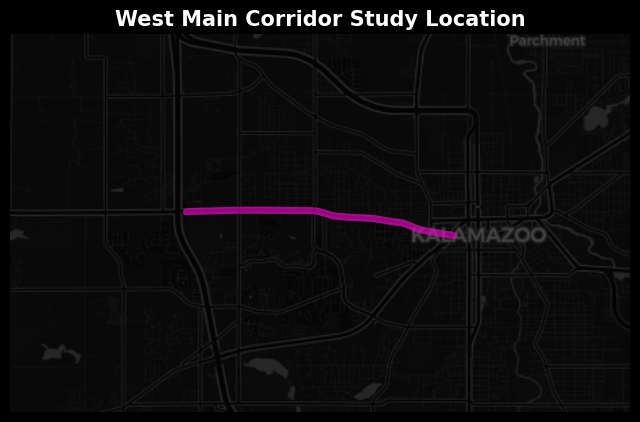

In [6]:
plt.style.use('dark_background')
ax = gdf.iloc[:1].plot(figsize=(8, 10), color='#fc03d3', alpha=0.6) #only 1 feature needed after union
# ax.set_xlim(left=-9536805, right=-9525239);
# ax.set_ylim(bottom=5201747, top=5209100);
x = 5000
ax.set_xlim(left=b[0]-x, right=b[2]+x);
ax.set_ylim(bottom=b[1]-x, top=b[3]+x);
ax.set_axis_off()
ax.set_title('West Main Corridor Study Location', fontsize=15, fontweight='bold')
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter, attribution=False, zoom=12)

## West Main Corridor CSV Data

In [7]:
!head -n 11 'data/kzoo_street_12225/1861928_West_Main_Street/1861928_West_Main_Street_corridor_study.csv'

Data Periods,Mode of Travel,Zone ID,Zone Name,Road Classification,Line Zone Length (Miles),Zone Is Pass Through,Zone Direction (degrees),Zone Cardinal Direction,Zone is Bi-Direction,Day Type,Day Part,Average Daily Segment Traffic (StL Volume),Avg Segment Speed (mph),Avg Segment Travel Time (sec),Free Flow Speed (mph),Vehicle Miles of Travel (StL Volume),Travel Time Index,Congested Segment,85th Speed Percentile
"Jan 01, 2022 - Dec 31, 2023",All Vehicles - StL All Vehicles Volume,1111503841,West Main Street / 111568112 / 7,Primary,0.031,yes,92,EAST,yes,0: All Days (M-Su),00: All Day (12am-12am),11509,40,3,44.303,360.04,1.12,false,45
"Jan 01, 2022 - Dec 31, 2023",All Vehicles - StL All Vehicles Volume,1111503841,West Main Street / 111568112 / 7,Primary,0.031,yes,92,EAST,yes,0: All Days (M-Su),01: 12am (12am-1am),125,40,3,44.303,3.92,1.09,false,46
"Jan 01, 2022 - Dec 31, 2023",All Vehicles - StL All Vehicles Volume,1111503841,West Main Street / 111568112 / 7,Primary,0.031,yes,92,EAST,yes,0

## Data Analysis

Load West Main Traffic data into Pandas Dataframe   
4770 Records - Basic statistics for each attribute   

In [8]:
df = pd.read_csv('data/kzoo_street_12225/1861928_West_Main_Street/1861928_West_Main_Street_corridor_study.csv')
df.describe().drop(columns=['Zone ID']).style \
    .format(precision=1, thousands="", decimal=".") 

,Line Zone Length (Miles),Zone Direction (degrees),Average Daily Segment Traffic (StL Volume),Avg Segment Speed (mph),Avg Segment Travel Time (sec),Free Flow Speed (mph),Vehicle Miles of Travel (StL Volume),Travel Time Index,85th Speed Percentile
count,4770.0,4770.0,4770.0,4770.0,4770.0,4770.0,4770.0,4770.0,4770.0
mean,0.1,96.4,1212.9,37.7,6.5,43.2,83.8,1.2,45.2
std,0.1,5.9,2299.5,4.4,5.7,3.8,230.9,0.1,3.2
min,0.0,88.0,21.0,19.0,1.0,21.8,0.4,1.0,30.0
25%,0.0,92.0,228.0,36.0,3.0,42.9,9.5,1.1,44.0
50%,0.1,94.0,647.0,39.0,5.0,43.8,25.8,1.1,45.0
75%,0.1,100.0,905.8,40.0,8.0,44.8,64.9,1.2,47.0
max,0.3,112.0,17452.0,46.0,33.0,47.4,4593.1,1.6,53.0


30 Different categories for `Day Part` attribute   
Filter for 'All Day (12am-12am)'   
This should provide traffic for the entire day and eliminate duplicates

In [9]:
df['Day Part'].unique()

array(['00: All Day (12am-12am)', '01: 12am (12am-1am)',
       '02: Early AM (12am-6am)', '03: 1am (1am-2am)',
       '04: 2am (2am-3am)', '05: 3am (3am-4am)', '06: 4am (4am-5am)',
       '07: 5am (5am-6am)', '08: 6am (6am-7am)', '09: Peak AM (6am-10am)',
       '10: 7am (7am-8am)', '11: 8am (8am-9am)', '12: 9am (9am-10am)',
       '13: 10am (10am-11am)', '14: Mid-Day (10am-4pm)',
       '15: 11am (11am-12noon)', '16: 12pm (12noon-1pm)',
       '17: 1pm (1pm-2pm)', '18: 2pm (2pm-3pm)', '19: 3pm (3pm-4pm)',
       '20: 4pm (4pm-5pm)', '21: Peak PM (4pm-8pm)', '22: 5pm (5pm-6pm)',
       '23: 6pm (6pm-7pm)', '24: 7pm (7pm-8pm)', '25: 8pm (8pm-9pm)',
       '26: Late PM (8pm-12am)', '27: 9pm (9pm-10pm)',
       '28: 10pm (10pm-11pm)', '29: 11pm (11pm-12am)'], dtype=object)

We now have reduced `4770` records to `53`   
This represents one record per road segment/Zone ID   
Let's drop some of the uneeded columns to help the analysis

In [10]:
df_day_part = df[(df['Day Part'] == '00: All Day (12am-12am)') & (df['Day Type'] == '0: All Days (M-Su)')]
df_day_part.count()

Data Periods                                  53
Mode of Travel                                53
Zone ID                                       53
Zone Name                                     53
Road Classification                           53
Line Zone Length (Miles)                      53
Zone Is Pass Through                          53
Zone Direction (degrees)                      53
Zone Cardinal Direction                       53
Zone is Bi-Direction                          53
Day Type                                      53
Day Part                                      53
Average Daily Segment Traffic (StL Volume)    53
Avg Segment Speed (mph)                       53
Avg Segment Travel Time (sec)                 53
Free Flow Speed (mph)                         53
Vehicle Miles of Travel (StL Volume)          53
Travel Time Index                             53
Congested Segment                             53
85th Speed Percentile                         53
dtype: int64

In [11]:
c = df_day_part.columns
df_filter = df_day_part[[c[2], c[5], c[10], c[12], c[13], c[15], c[19]]]
df_filter.set_index(df_day_part['Zone ID'], inplace=True)
df_filter.head()

,Zone ID,Line Zone Length (Miles),Day Type,Average Daily Segment Traffic (StL Volume),Avg Segment Speed (mph),Free Flow Speed (mph),85th Speed Percentile
Zone ID,,,,,,,
1111503841,1111503841,0.031,0: All Days (M-Su),11509,40,44.303,45
1111754274,1111754274,0.017,0: All Days (M-Su),11450,37,42.516,43
1111871475,1111871475,0.062,0: All Days (M-Su),12575,34,43.484,45
1112032394,1112032394,0.031,0: All Days (M-Su),11558,39,44.121,45
1112161013,1112161013,0.190,0: All Days (M-Su),16557,33,44.298,45


## Traffic Data Summary

#### Raw Traffic Data - All Entries First
Rename attribute columns

In [12]:
dfc = df.copy(deep=True)
dfc.rename(columns={'Average Daily Segment Traffic (StL Volume)': 'Avg Daily Seg Traffic ', \
                    'Avg Segment Speed (mph)': 'Avg Seg Spd (mph)', 
                    '85th Speed Percentile': '85th Spd PCTL', 
                    'Line Zone Length (Miles)': 'Zone Length (mi)', 
                    'Free Flow Speed (mph)': 'Free Flow Spd (mph)' }, inplace=True)
dc = dfc.columns
print([(i, item) for i, item in enumerate(dc)]) 

[(0, 'Data Periods'), (1, 'Mode of Travel'), (2, 'Zone ID'), (3, 'Zone Name'), (4, 'Road Classification'), (5, 'Zone Length (mi)'), (6, 'Zone Is Pass Through'), (7, 'Zone Direction (degrees)'), (8, 'Zone Cardinal Direction'), (9, 'Zone is Bi-Direction'), (10, 'Day Type'), (11, 'Day Part'), (12, 'Avg Daily Seg Traffic '), (13, 'Avg Seg Spd (mph)'), (14, 'Avg Segment Travel Time (sec)'), (15, 'Free Flow Spd (mph)'), (16, 'Vehicle Miles of Travel (StL Volume)'), (17, 'Travel Time Index'), (18, 'Congested Segment'), (19, '85th Spd PCTL')]


In [13]:
dfc[[dc[5], dc[12], dc[13],dc[15],dc[19]]].describe().T.drop(columns=['25%', '50%', '75%']).style \
  .format(precision=2, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .set_caption('<h2>West Main All Segments/Day Part Stats</h3>') \
  .relabel_index([f'<b>{dc[5]}<br>',f'<b>{dc[12]}<br>',f'<b>{dc[13]}<br>',f'<b>{dc[15]}<br>',f'<b>{dc[19]}<br>'], axis=0) \
  .set_table_styles([{"selector": "tr", "props": [("height", "36px")]}]) 

,COUNT,MEAN,STD,MIN,MAX
Zone Length (mi),"4,770.00",0.07,0.05,0.01,0.29
Avg Daily Seg Traffic,"4,770.00","1,212.85","2,299.47",21.00,"17,452.00"
Avg Seg Spd (mph),"4,770.00",37.67,4.44,19.00,46.00
Free Flow Spd (mph),"4,770.00",43.24,3.76,21.80,47.42
85th Spd PCTL,"4,770.00",45.18,3.20,30.00,53.00


#### Filtered Traffic Data - `Day Part` = 'All Day (12am-12am)'

In [14]:
df_atc = df_filter.copy(deep=True)
df_atc.rename(columns={'Average Daily Segment Traffic (StL Volume)': 'Avg Daily Seg Traffic ', \
                    'Avg Segment Speed (mph)': 'Avg Seg Spd (mph)', 
                    '85th Speed Percentile': '85th Spd PCTL', 
                    'Line Zone Length (Miles)': 'Zone Length (mi)', 
                    'Free Flow Speed (mph)': 'Free Flow Spd (mph)' }, inplace=True)
dc = df_atc.columns

In [15]:
df_atc[[dc[1], dc[3], dc[4], dc[5], dc[6]]].describe().T.drop(columns=['count', '25%', '50%', '75%']).style \
  .format(precision=2, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .set_caption('<h2>West Main Filtered - Day Part - Stats</h2>') \
  .relabel_index([f'<b>{dc[1]}<br>',f'<b>{dc[3]}<br>',f'<b>{dc[4]}<br>',f'<b>{dc[5]}<br>',f'<b>{dc[6]}<br>'], axis=0) \
  .set_table_styles([{"selector": "tr", "props": [("height", "36px")]}]) 

,MEAN,STD,MIN,MAX
Zone Length (mi),0.07,0.05,0.01,0.29
Avg Daily Seg Traffic,"12,565.70","1,747.09","9,173.00","16,557.00"
Avg Seg Spd (mph),36.66,4.22,19.00,43.00
Free Flow Spd (mph),43.24,3.80,21.80,47.42
85th Spd PCTL,44.55,2.93,32.00,50.00


#### Free Flow Speed Outliers
Here we can see there are a few `Free Flow Spd (mph)` values that are much lower than the others   
We will see that that these are the furthest easterly segments of West Main, as it slows down into the intersection with Michikal/Stadium etc...

In [16]:
ff_spd_std = df_atc['Free Flow Spd (mph)'].std()
ff_spd_mean = df_atc['Free Flow Spd (mph)'].mean()
ff_spd_min = df_atc['Free Flow Spd (mph)'].min()
ff_spd_max = df_atc['Free Flow Spd (mph)'].max()
print(f'Free Flow Speed (mph) Standard Dev: {round(ff_spd_std, 3)} - Mean: {round(ff_spd_mean,3)} - Min: {round(ff_spd_min,2)} - Max: {round(ff_spd_max, 2)}')

Free Flow Speed (mph) Standard Dev: 3.8 - Mean: 43.243 - Min: 21.8 - Max: 47.42


Removing Free Flow outliers to 2 x std   
Min is now `38.6` vs `21.8`   
This will yield a better visualization

In [17]:
df_atc_o = df_atc.copy(deep=True) 

df_atc_o = df_atc_o[(df_atc_o['Free Flow Spd (mph)'] >= ff_spd_mean - ff_spd_std*2) & \
                     (df_atc_o['Free Flow Spd (mph)'] <= ff_spd_mean + ff_spd_std*2)  ]

spd_std = df_atc_o['Free Flow Spd (mph)'].std()
spd_mean = df_atc_o['Free Flow Spd (mph)'].mean()
spd_min = df_atc_o['Free Flow Spd (mph)'].min()
spd_max = df_atc_o['Free Flow Spd (mph)'].max()

print(f'Free Flow Speed (mph) Standard Dev: {round(spd_std, 3)} - Mean: {round(spd_mean,2)} - Min: {round(spd_min,1)} - Max: {round(spd_max,1)}')

Free Flow Speed (mph) Standard Dev: 1.806 - Mean: 43.87 - Min: 38.6 - Max: 47.4


In [18]:
df_atc_o[[dc[1], dc[3], dc[4], dc[5], dc[6]]].describe().T.drop(columns=['count', '25%', '50%', '75%']).style \
  .format(precision=2, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .set_caption('<h2>West Main Filtered - No Outliers - Stats</h2>') \
  .relabel_index([f'<b>{dc[1]}<br>',f'<b>{dc[3]}<br>',f'<b>{dc[4]}<br>',f'<b>{dc[5]}<br>',f'<b>{dc[6]}<br>'], axis=0) \
  .set_table_styles([{"selector": "tr", "props": [("height", "36px")]}]) 

,MEAN,STD,MIN,MAX
Zone Length (mi),0.07,0.06,0.01,0.29
Avg Daily Seg Traffic,"12,453.27","1,683.08","9,173.00","16,557.00"
Avg Seg Spd (mph),37.20,3.19,27.00,43.00
Free Flow Spd (mph),43.87,1.81,38.56,47.42
85th Spd PCTL,44.94,2.11,39.00,50.00


## Traffic Data Visualization

A function that provides nice color bars for each field

In [19]:
def bar_with_colormap(val: int | float, vmin: int | float, vmax: int | float, cmap_name: str, opacity: float=1.0, wdth: int=100 ) -> str:
    norm = (val - vmin) / (vmax - vmin)  
    colormap = cm.get_cmap(cmap_name)  
    rgba = colormap(norm)  
    rgb_str = f"{int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}"
    styles = []
    bar_style = f'background: linear-gradient(90deg, rgba({rgb_str}, {opacity}) {norm*wdth}%, transparent {norm*wdth}%); border: 1px solid rgba(100, 100, 100, .6);'
    styles.append(bar_style)
    return bar_style

In [20]:
import colormaps as c
z, a, w, s = 0, 0.5, 60, 2
df_atc_o.drop(columns=['Zone ID' , 'Day Type']).style \
.set_table_styles([
    {"selector": "th", "props": [("width", "100px"), ("text-align", "center")]}, 
    {"selector": "tr", "props": [("color", "#e6e6e6"), ("text-align", "center"), ("background-color", "#1a1a1a")]},
    {"selector": "td, th", "props": [("border", "none")]}, 
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#1f1f1f')]},  # Alternate row color
     ]) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[6]].min()-s, 
            vmax=df_atc_o[dc[6]].max(), 
            cmap_name=f'{c.uni[0]}', 
            opacity=a, 
            wdth=w), 
        subset=['85th Spd PCTL']) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[5]].min()-s, 
            vmax=df_atc_o[dc[5]].max(), 
            cmap_name=c.uni[z], 
            opacity=a, 
            wdth=w), 
        subset=['Free Flow Spd (mph)']) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[4]].min()-s, 
            vmax=df_atc_o[dc[4]].max(), 
            cmap_name=c.uni[z], 
            opacity=a, 
            wdth=w), 
        subset=['Avg Seg Spd (mph)']) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[3]].min()-200, 
            vmax=df_atc_o[dc[3]].max(), 
            cmap_name=c.seq[2], 
            opacity=a, 
            wdth=w), 
        subset=['Avg Daily Seg Traffic ']) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[1]].min()-.02, 
            vmax=df_atc_o[dc[1]].max(), 
            cmap_name=f'{c.seq[0]}', 
            opacity=1.0, 
            wdth=w), 
        subset=['Zone Length (mi)']) \
.format(precision=2, thousands=",", decimal=".")


,Zone Length (mi),Avg Daily Seg Traffic,Avg Seg Spd (mph),Free Flow Spd (mph),85th Spd PCTL
Zone ID,,,,,
1111503841,0.03,"11,509",40,44.30,45
1111754274,0.02,"11,450",37,42.52,43
1111871475,0.06,"12,575",34,43.48,45
1112032394,0.03,"11,558",39,44.12,45
1112161013,0.19,"16,557",33,44.30,45
1112668374,0.03,"11,473",38,43.47,44
1112849422,0.05,"11,463",33,39.88,42
1113019695,0.02,"11,408",39,44.84,46
1113040226,0.06,"12,398",37,43.79,44


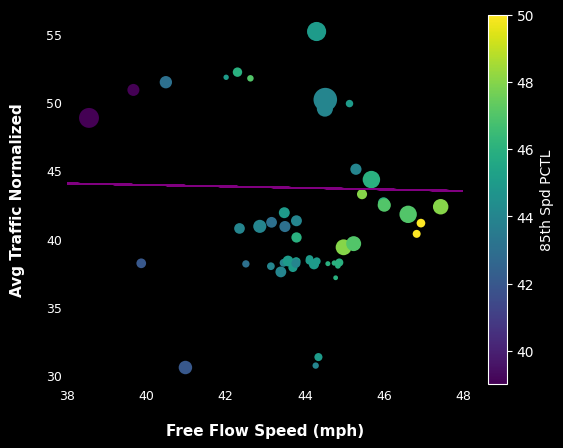

In [21]:
# Create new copy of dataframe
df_atc_o_area = df_atc_o.copy(deep=True)

# normalizing fields
df_atc_o_area['Avg_Traffic_Norm'] = df_atc_o_area['Avg Daily Seg Traffic '].apply(lambda x: x/300)
df_atc_o_area['Zone_Length_Norm'] = df_atc_o_area['Zone Length (mi)'].apply(lambda x: x*1000)
df_atc_o_area['Avg_Traffic_Plot'] = df_atc_o_area['Avg_Traffic_Norm'].apply(lambda x: x*5)
df_atc_o_area['85th_Norm'] = df_atc_o_area['85th Spd PCTL'].apply(lambda x: x*100)

ax = df_atc_o_area.plot.scatter(
    y='Avg_Traffic_Norm', 
    x="Free Flow Spd (mph)", 
    s='Zone_Length_Norm', 
    c='85th Spd PCTL', 
    cmap="viridis",
    edgecolor='none',
    legend=False);

# formatting
ax.set_xlim(38, 48);
[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(axis='both', which='both', length=0, labelsize=9)
ax.set_ylabel('Avg Traffic Normalized', fontsize=11, fontweight='bold', color='white', labelpad=15)
ax.set_xlabel('Free Flow Speed (mph)', fontsize=11, fontweight='bold', color='white', labelpad=15)

# trendline
m, b = np.polyfit(df_atc_o_area['Avg_Traffic_Norm'], df_atc_o_area["Free Flow Spd (mph)"], 1)  # 1st-degree polynomial (linear fit)
df_atc_o_area['Trendline'] = m * df_atc_o_area['Avg_Traffic_Norm'] + b  # Compute Y values
ax.plot(df_atc_o_area['Avg_Traffic_Norm'], df_atc_o_area['Trendline'], color='purple', linestyle='solid', linewidth=1, label='Trendline');

#### Spatial Data Visualization

In [ ]:
os.chdir(os.path.expanduser('geodata-py-utils'))
from geodata_py_utils import GeoData, InputTypes

Load west_main geojson using GeoData library

In [139]:
file_path = '/home/pi/dev/notebooks/kzoo_streetlight/west_main_corridor.geojson' #change which geojson to load
geo_data = GeoData(file_path, InputTypes.DATA_PATH)
geo_data.gdf.head(3)

,id,segment_id,name,segment_ty,geometry
0,0,1111503841,West Main Street / 111568112 / 7,primary,"LINESTRING (-85.61777 42.29486, -85.61716 42.2..."
1,1,1111754274,West Main Street / 727695179 / 1,primary,"LINESTRING (-85.62555 42.2955, -85.62523 42.29..."
2,2,1111871475,West Main Street / 264373332 / 7,primary,"LINESTRING (-85.63055 42.29619, -85.62977 42.2..."


Join traffic data to segments using Zone ID/ segment_id

In [140]:
df_atc.set_index(df_atc['Zone ID'], inplace=True)
data = df_atc.to_dict('index')
data[1111503841]

{'Zone ID': 1111503841,
 'Zone Length (mi)': 0.031,
 'Day Type': '0: All Days (M-Su)',
 'Avg Daily Seg Traffic ': 11509,
 'Avg Seg Spd (mph)': 40,
 'Free Flow Spd (mph)': 44.303,
 '85th Spd PCTL': 45}

Join traffic data to segments using Zone ID/ segment_id

In [141]:
data = df_atc.to_dict('index')
new_gj = {'type': 'FeatureCollection', 'features': []}
for f in geo_data.geojson['features']:
    f['properties'].update(data[f['properties']['segment_id']])
    new_gj['features'].append(f)
new_gj['features'][0]

{'id': '0',
 'type': 'Feature',
 'properties': {'id': '0',
  'segment_id': 1111503841,
  'name': 'West Main Street / 111568112 / 7',
  'segment_ty': 'primary',
  'Zone ID': 1111503841,
  'Zone Length (mi)': 0.031,
  'Day Type': '0: All Days (M-Su)',
  'Avg Daily Seg Traffic ': 11509,
  'Avg Seg Spd (mph)': 40,
  'Free Flow Spd (mph)': 44.303,
  '85th Spd PCTL': 45},
 'geometry': {'type': 'LineString',
  'coordinates': [[-85.61777353286743, 42.29485583305359],
   [-85.61715984344482, 42.29484176635742]]}}

In [147]:
geo_data_join = GeoData(new_gj, InputTypes.DATA_FEATURES)
geo_data_join.geojson['features'][0]

{'id': '0',
 'type': 'Feature',
 'properties': {'id': '0',
  'segment_id': 1111503841,
  'name': 'West Main Street / 111568112 / 7',
  'segment_ty': 'primary',
  'Zone ID': 1111503841,
  'Zone Length (mi)': 0.031,
  'Day Type': '0: All Days (M-Su)',
  'Avg Daily Seg Traffic ': 11509,
  'Avg Seg Spd (mph)': 40,
  'Free Flow Spd (mph)': 44.303,
  '85th Spd PCTL': 45},
 'geometry': {'type': 'LineString',
  'coordinates': [[-85.61777353286743, 42.29485583305359],
   [-85.61715984344482, 42.29484176635742]]}}

In [148]:
join_gdf = geo_data_join.gdf
join_gdf.set_crs(epsg=4326, inplace=True)
join_gdf.to_crs(epsg=3857, inplace=True)
join_gdf.crs
b2 = join_gdf.total_bounds #map cooridinate bounds
b2

array([-9535805.17429403,  5204747.15539218, -9528239.97866332,
        5205463.82515336])

In [ ]:
plt.style.use('dark_background')
ax = join_gdf.plot(figsize=(18, 10), color='#fc03d3', alpha=0.6, linewidth=10) #only 1 feature needed after union
# ax.set_xlim(left=-9536805, right=-9525239);
# ax.set_ylim(bottom=5201747, top=5209100);
x = 5000
ax.set_xlim(left=b2[0]-x, right=b2[2]+x);
ax.set_ylim(bottom=b2[1]-4000, top=b2[3]+4000);
ax.set_axis_off()
ax.set_title('West Main Corridor Study Location', fontsize=15, fontweight='bold')
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter, attribution=False, zoom=12)


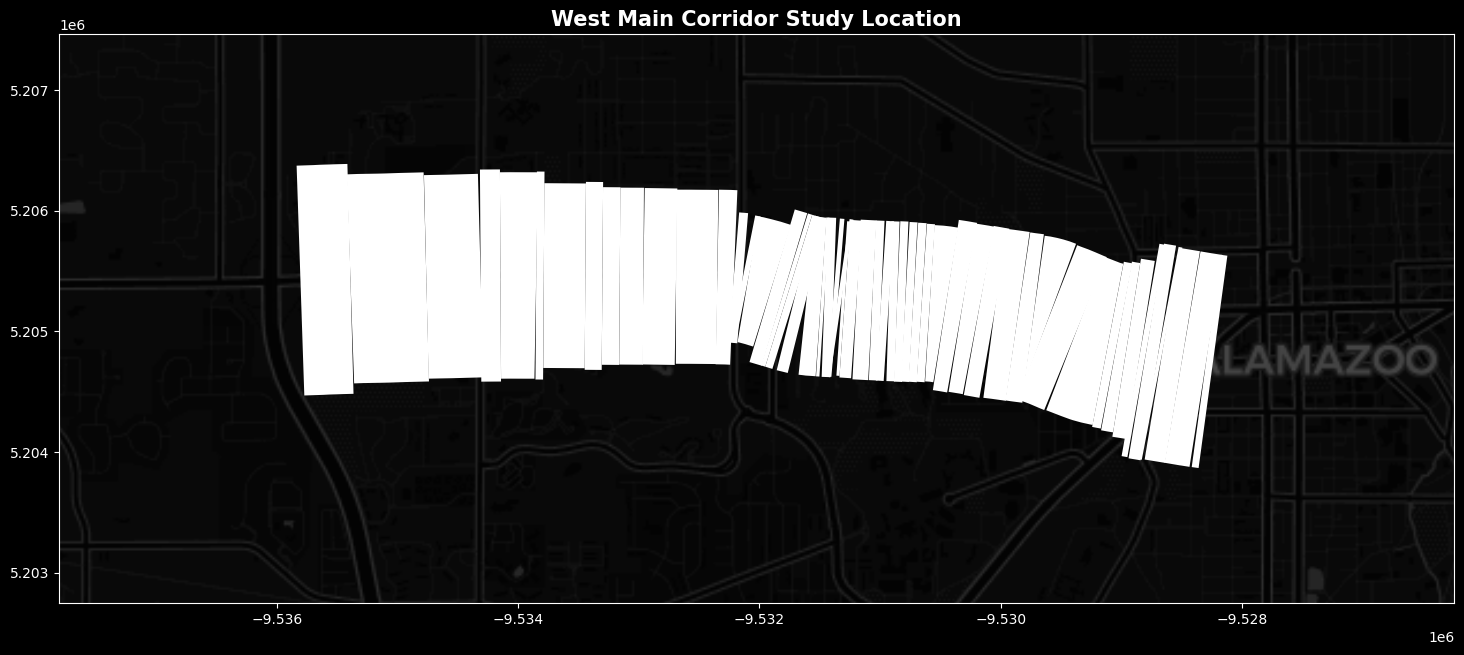

In [208]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# ax = join_gdf.plot(figsize=(18, 10), color='#fc03d3', alpha=0.6, linewidth=10) #only 1 feature needed after union
fig, ax = plt.subplots(figsize=(18,10))
# Normalize attribute values to fit color map
norm = colors.Normalize(vmin=join_gdf['Avg Daily Seg Traffic '].min(), vmax=join_gdf['Avg Daily Seg Traffic '].max())
cmap = cm.get_cmap("viridis")

for _, row in join_gdf.iterrows():
    linewidth = row['Avg Daily Seg Traffic '] / 100  # Scale line width by speed
    # color = row["color"]          # Use color attribute
    gpd.GeoSeries(row.geometry).plot(ax=ax, linewidth=linewidth)#, color=color)

x = 2000
ax.set_xlim(left=b2[0]-x, right=b2[2]+x);
ax.set_ylim(bottom=b2[1]-x, top=b2[3]+x);
ax.set_title('West Main Corridor Study Location', fontsize=15, fontweight='bold')
# ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter, attribution=False, zoom=13)

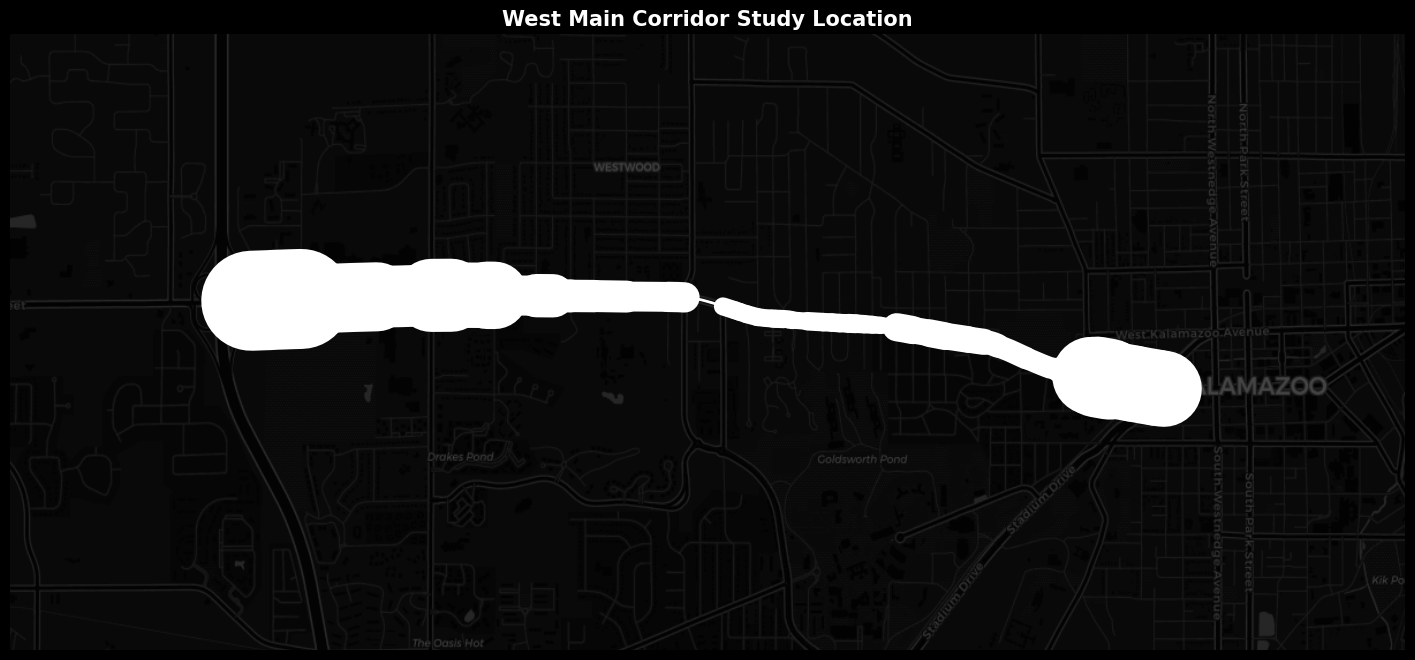

In [294]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
#
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
join_gdf["normalized_traffic"] = scaler.fit_transform(join_gdf[['Avg Daily Seg Traffic ']])
offset = 0.2  # This makes sure no value is exactly 0
join_gdf["normalized_traffic"] = join_gdf["normalized_traffic"] + offset
join_gdf["line_width"] = (join_gdf["normalized_traffic"] ** 2) * 50
# 
fig, ax = plt.subplots(figsize=(18,8))
lines = [list(row.geometry.coords) for _, row in join_gdf.iterrows()]
widths = (join_gdf['Avg Daily Seg Traffic '] ** 1.7 / 100000) 
# colors = gdf["color"]
line_collection = LineCollection(
    lines,
    linewidths=join_gdf['line_width'],
    capstyle='round',  # Rounded ends
    alpha=1           # Full opacity
)
ax.add_collection(line_collection)
x = 2000
ax.set_xlim(left=b2[0]-x, right=b2[2]+x);
ax.set_ylim(bottom=b2[1]-x, top=b2[3]+x);
ax.set_title('West Main Corridor Study Location', fontsize=15, fontweight='bold')
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter, attribution=False, zoom=14)

In [280]:
join_gdf["Avg Daily Seg Traffic "].min()

np.int64(9173)

In [192]:
cx.providers.CartoDB

{'Positron': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'light_all',
  'name': 'CartoDB.Positron'},
 'PositronNoLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'light_nolabels',
  'name': 'CartoDB.PositronNoLabels'},
 'PositronOnlyLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'light_only_labels',
  'name': 'CartoDB.PositronOnlyLabels'},
 'DarkMatter': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'dark_all',
  'name': 'CartoDB.DarkMatter'},
 'DarkMatterNoLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'dark_nolabels',
  'name': 'CartoDB.DarkMatterNoLabels'},
 'DarkMatterOnlyLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'dark_only_labels',
  'name': 'CartoDB.DarkMatterOnlyLabels'},
 'Voyager': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'rastertiles/voyager',
  'name': 'CartoDB.Voyager'},
 'VoyagerNoLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'rastertiles/voyager_nolabels',
  'name': 'CartoDB.VoyagerNoLabels'},
 'VoyagerOnlyLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'rastertiles/voyager_only_labels',
  'name': 'CartoDB.VoyagerOnlyLabels'},
 'VoyagerLabelsUnder': {'url': 'https://{s}.basema

In [296]:
geo_data_join.export_geojson('west_main_join')

GeoJSON output: west_main_join.geojson


## Conclusion